# Common

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
seed = 1111
np.random.seed(seed)

# Data Preparation

In [3]:
file_path = "/content/drive/MyDrive/Dataset/heart_statlog_cleveland_hungary_final.csv"
df = pd.read_csv(file_path)

In [4]:
df.head(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [5]:
# renaming features to proper name
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 
              'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 
              'max_heart_rate_achieved', 'exercise_induced_angina', 
              'st_depression', 'st_slope','target']

In [6]:
DROP = ['cholesterol', 'rest_ecg', 'st_depression', 'st_slope']
CONTI_COLS = ['age', 'sex', 'resting_blood_pressure', 
              'fasting_blood_sugar',
              'exercise_induced_angina', 'max_heart_rate_achieved'
              ]

CATE_COLS = ['chest_pain_type']
LABEL_COLS = "target"

In [7]:
df = df.drop(labels=DROP, axis=1)

In [8]:
df.head(5)

,age,sex,chest_pain_type,resting_blood_pressure,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,target
0,40,1,2,140,0,172,0,0
1,49,0,3,160,0,156,0,1
2,37,1,2,130,0,98,0,0
3,48,0,4,138,0,108,1,1
4,54,1,3,150,0,122,0,0


# Data Visualization

In [9]:
# Importing libraries for visualization data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
df['target'].value_counts()

1    629
0    561
Name: target, dtype: int64

In [11]:
# Any empty values?
df.isnull().sum()

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
fasting_blood_sugar        0
max_heart_rate_achieved    0
exercise_induced_angina    0
target                     0
dtype: int64

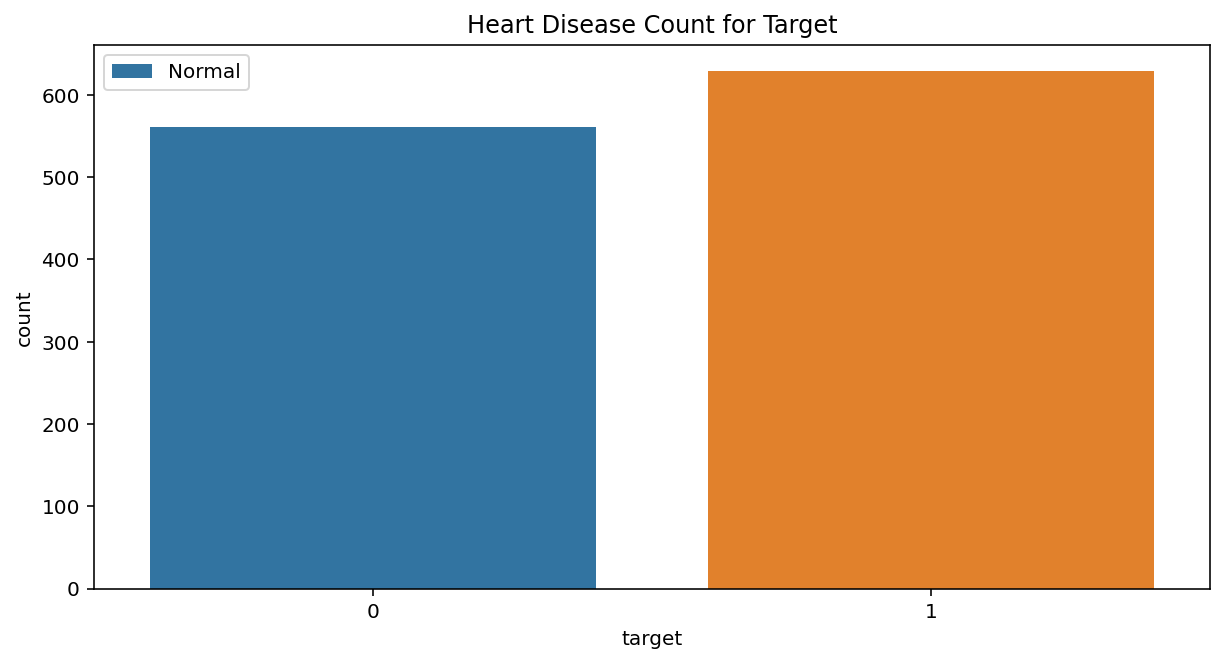

In [12]:
plt.figure(figsize=[10, 5])
plt.title('Heart Disease Count for Target')
sns.countplot(x='target', data=df)
plt.legend(["Normal", "Heart Disease"])
plt.show()

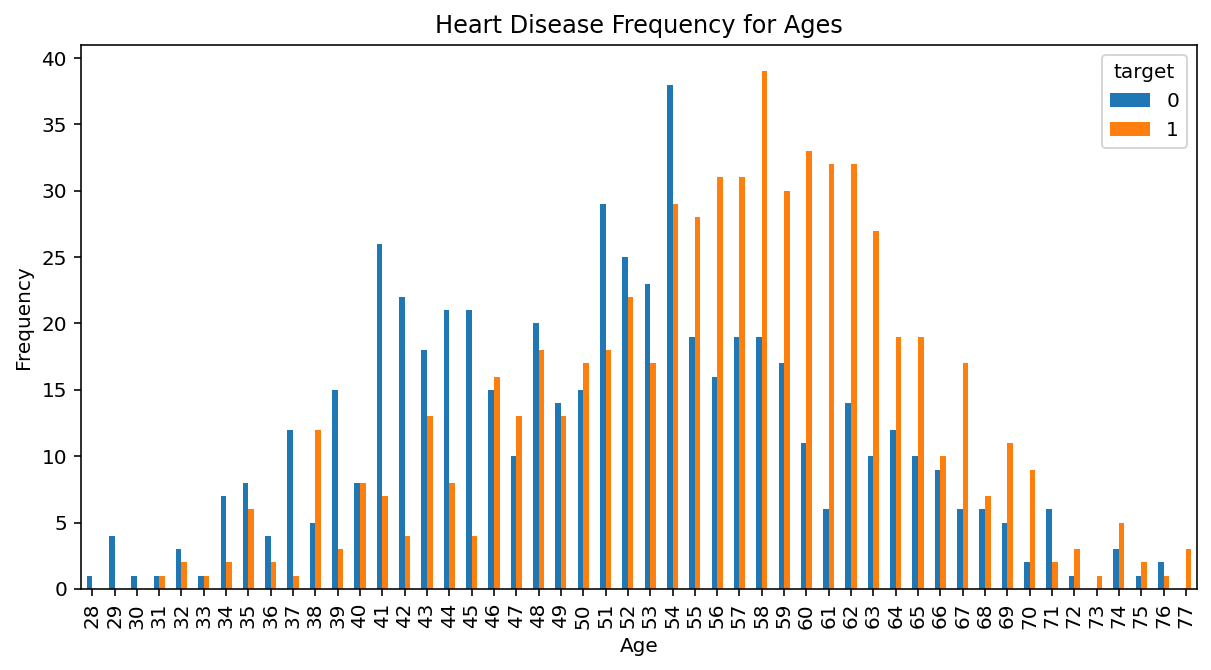

In [13]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(10,5))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

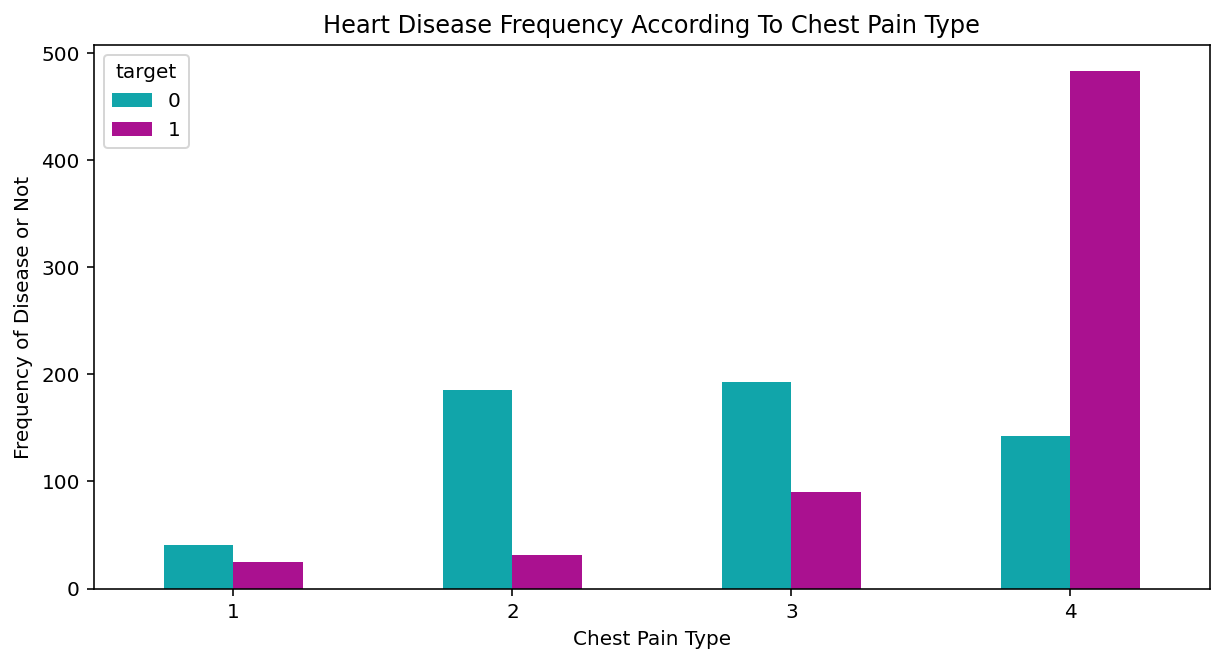

In [14]:
pd.crosstab(df.chest_pain_type,df.target).plot(kind="bar",figsize=(10,5),color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

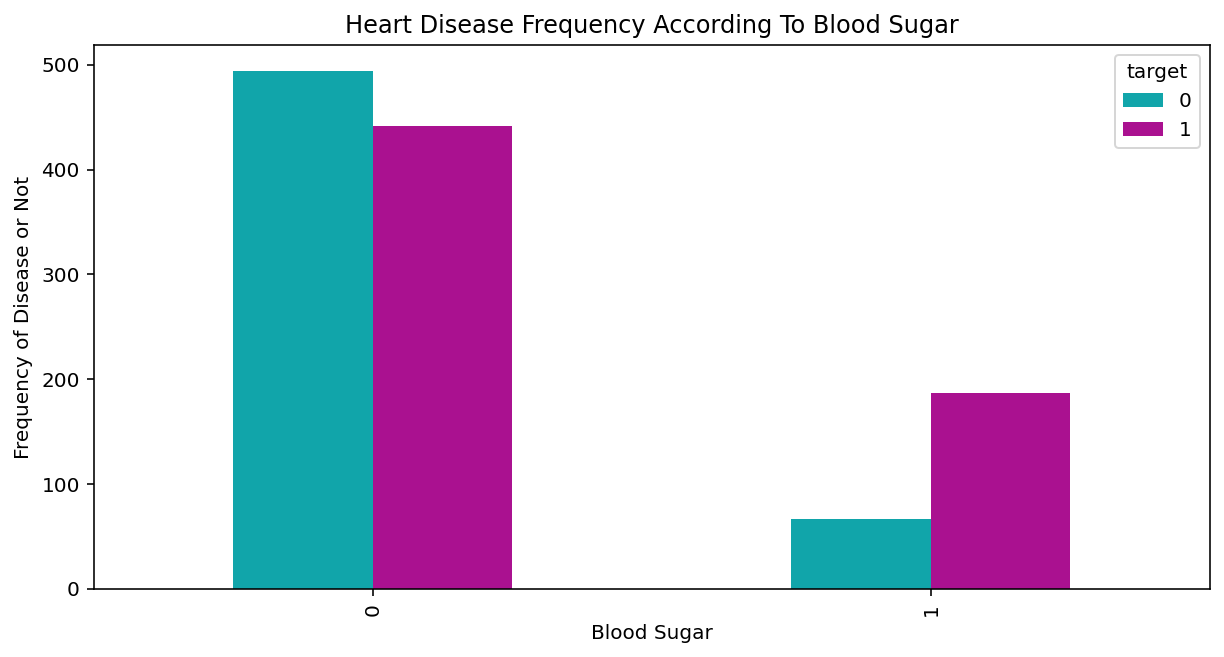

In [15]:
pd.crosstab(df.fasting_blood_sugar, df.target).plot(kind="bar",figsize=(10,5),color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Blood Sugar')
plt.xlabel('Blood Sugar')
plt.ylabel('Frequency of Disease or Not')
plt.show()

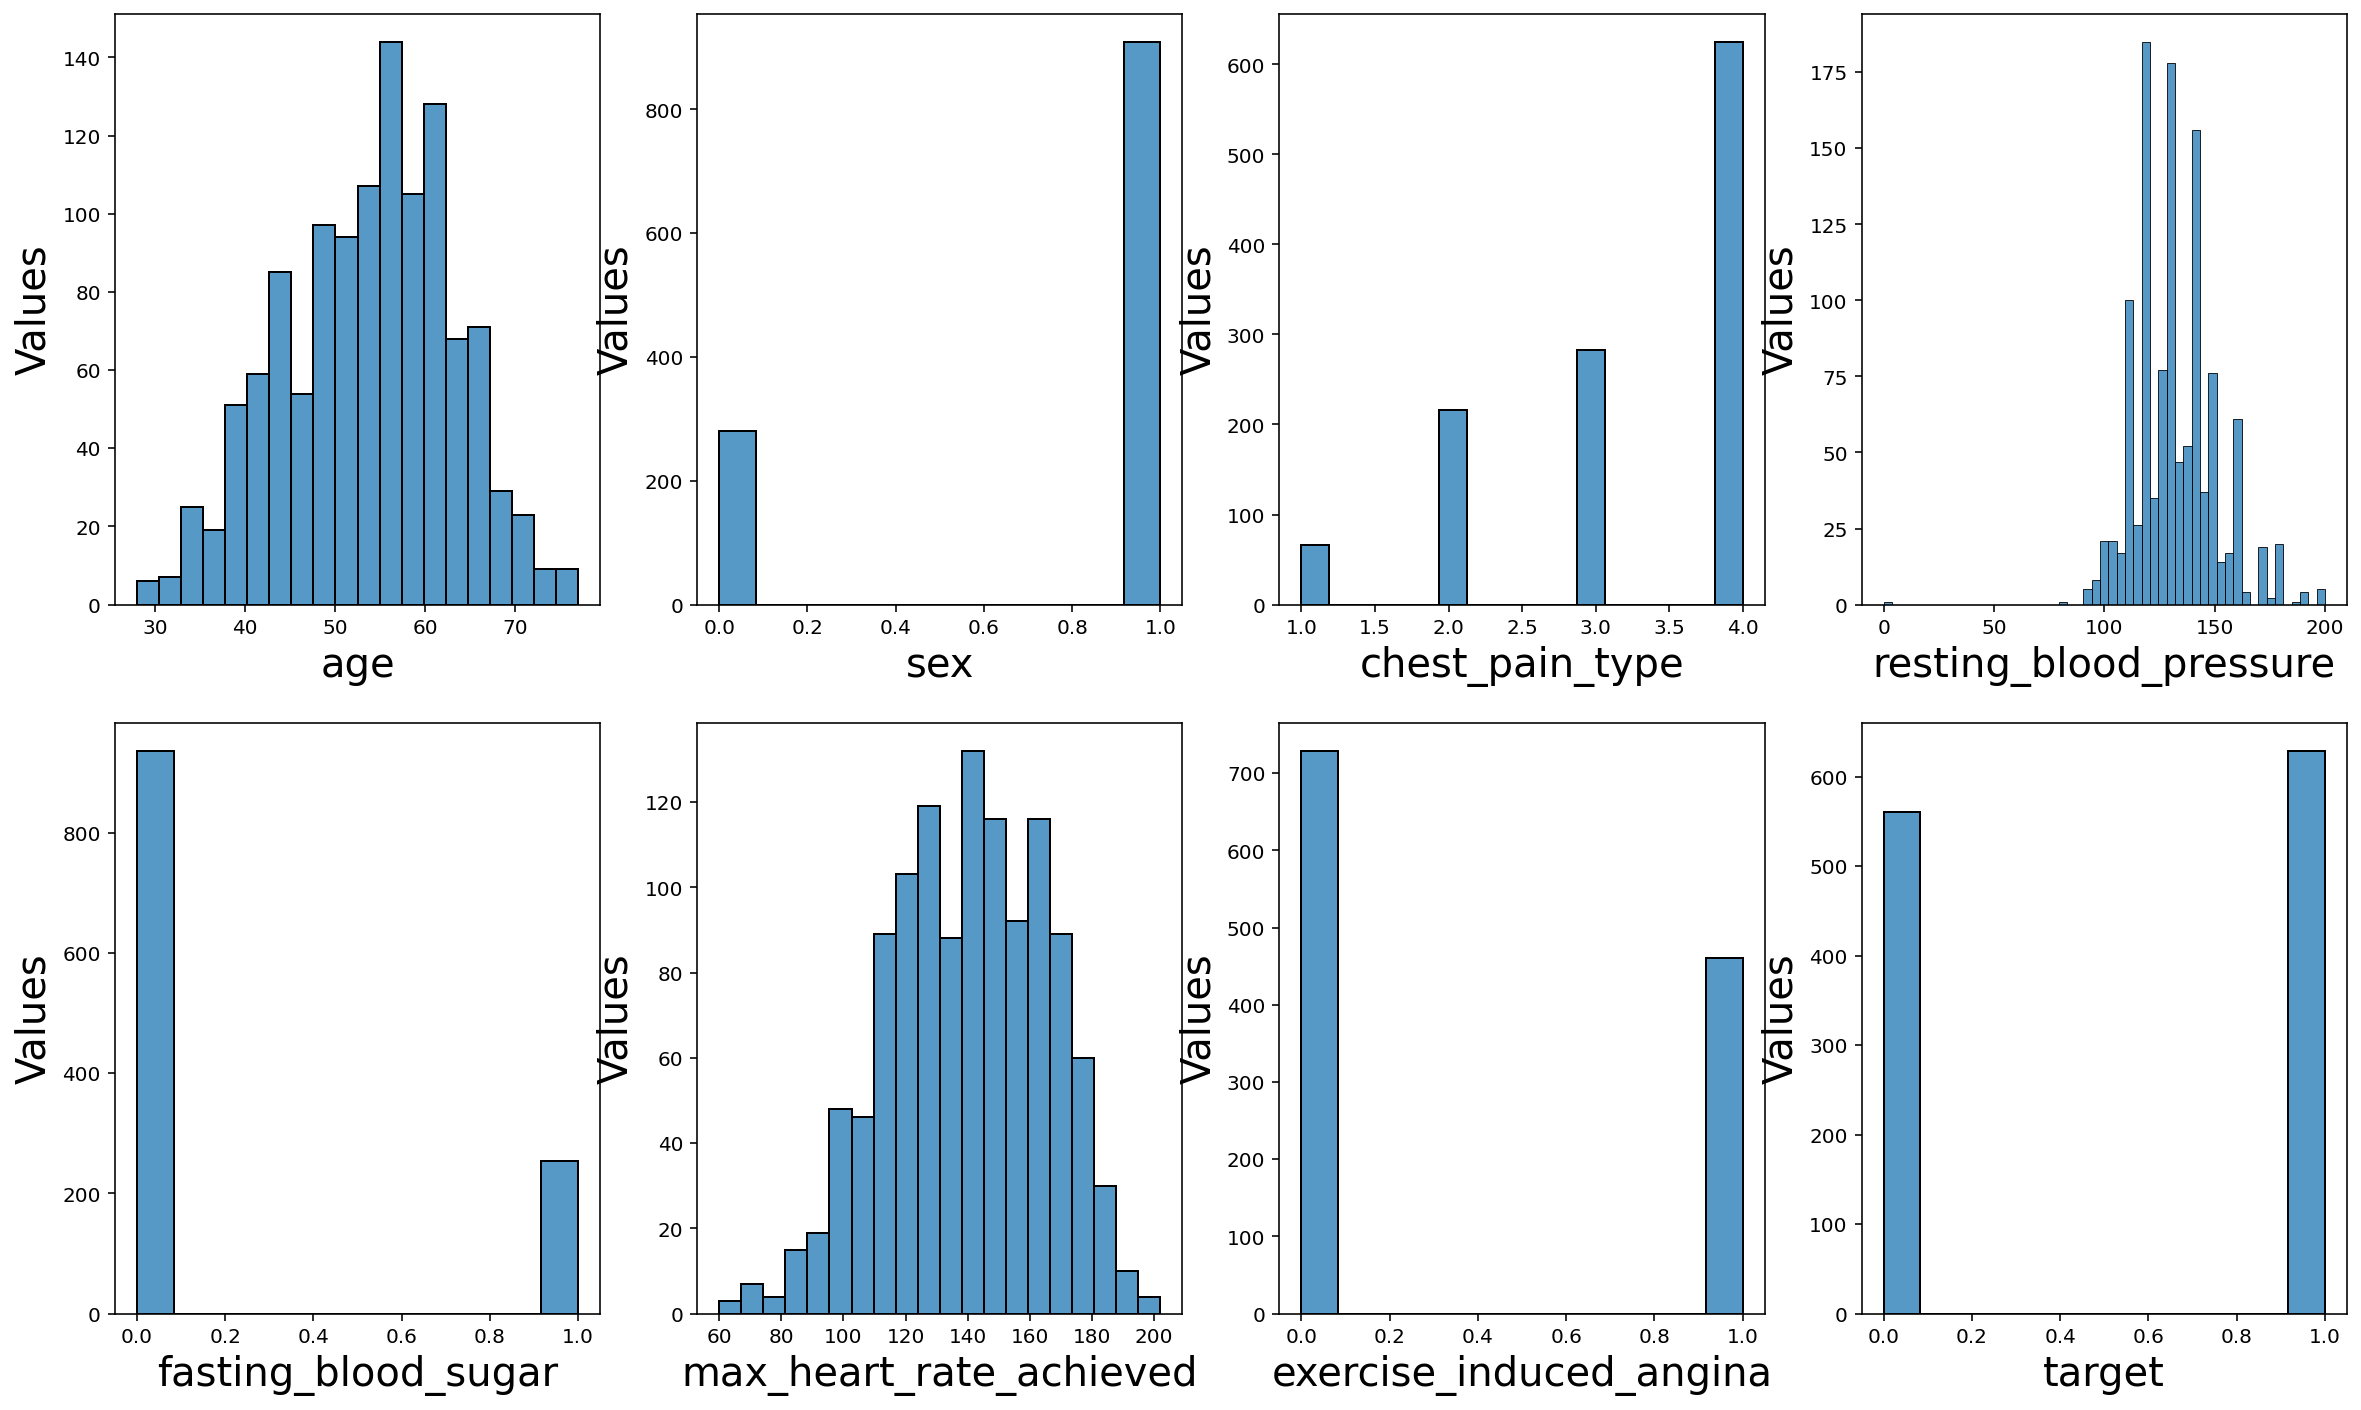

In [16]:
#Plotting the distribution plot.
plt.figure(figsize=(20,25))
plotnumber=1

for column in df:
  if plotnumber<14:
    ax=plt.subplot(4,4,plotnumber)
    sns.histplot(df[column])
    plt.xlabel(column,fontsize=20)
    plt.ylabel('Values',fontsize=20)
  plotnumber+=1
plt.show()

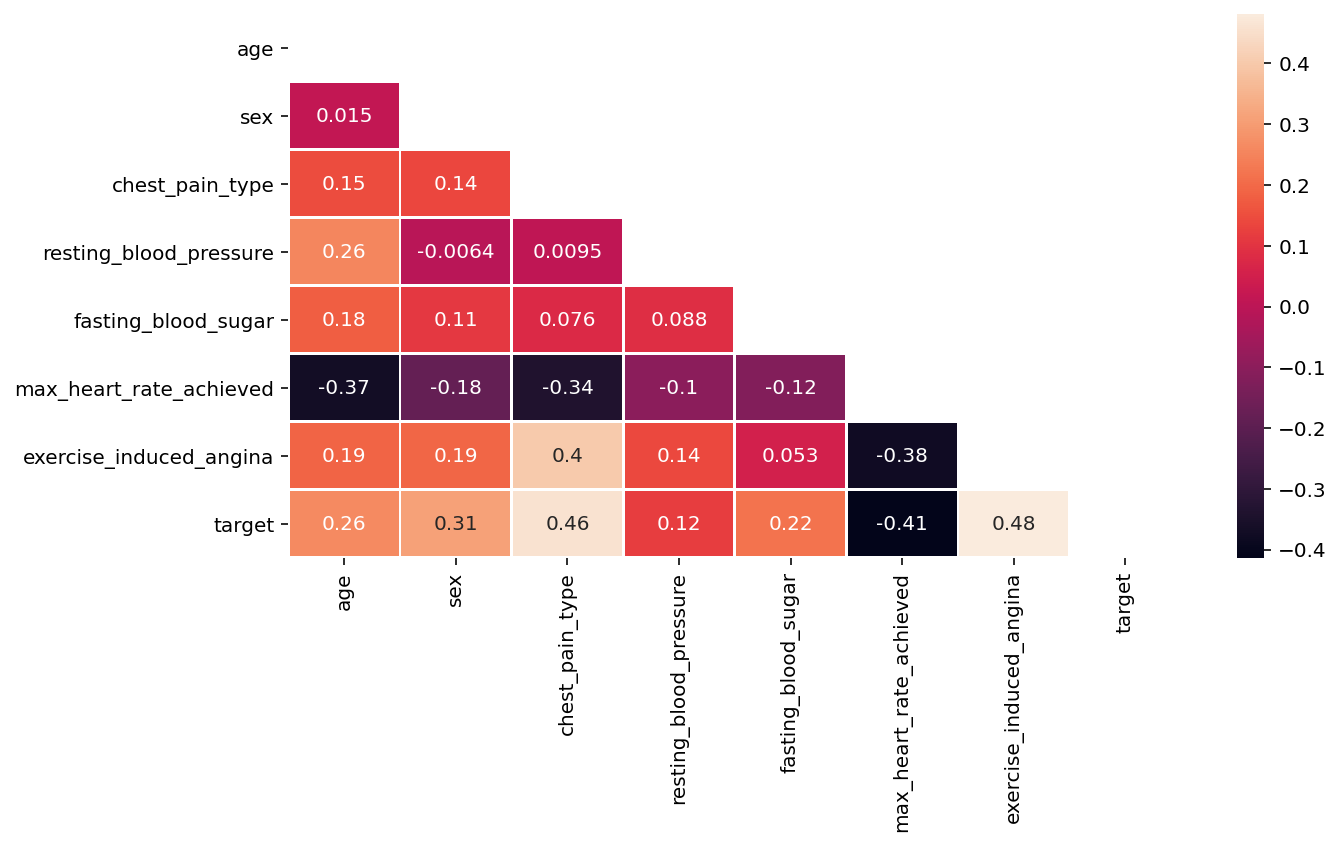

In [17]:
#Correlation matrix

plt.figure(figsize = (10, 5))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, annot = True, fmt = '.2g', linewidths = 1)
plt.show()

# Data Pre-prosseing

In [18]:
# Select the columns to use for prediction in the neural network
X = df.drop('target', axis=1)
Y = df[['target']]
print(X.shape, Y.shape, X.columns)

(1190, 7) (1190, 1) Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'fasting_blood_sugar', 'max_heart_rate_achieved',
       'exercise_induced_angina'],
      dtype='object')


# Model Building

In [19]:
# Importing libraries for building the neural network
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from keras.backend import clear_session

In [20]:
save_dir = '/content/saved_models/'

In [21]:
!rm -f /content/saved_models/*

In [22]:
def get_model_name(k):
    return 'best_trained_model_'+str(k)+'.h5'

In [23]:
def getModel():
  # create model with fully connected layers with dropout regulation
  model = Sequential()
  model.add(Dense(32, input_dim=7, kernel_initializer ='uniform', 
                  activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(12, kernel_initializer ='uniform', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, kernel_initializer ='uniform', activation='sigmoid'))

  return model

## Model Description

In [24]:
des = getModel()
des.compile(loss='binary_crossentropy', 
              optimizer="Adamax", 
              metrics=['accuracy'])
des.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                396       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 665
Trainable params: 665
Non-trainable params: 0
_________________________________________________________________


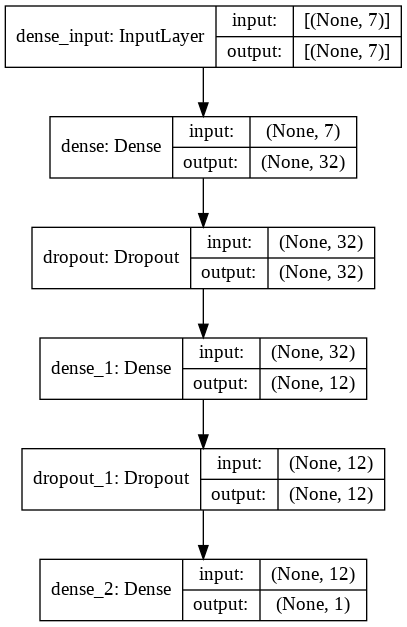

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(des, show_shapes=True, rankdir="TB")

## K-Fold Cross Validation

In [26]:
# Use for StratifiedKFold classification
kf = StratifiedKFold(5, shuffle=True, random_state=1111) 

fold = 0

for train, test in kf.split(X, Y):
  print("# Fold {}\n".format(fold))

  x_train = X.iloc[train]
  y_train = Y.iloc[train]
  x_test = X.iloc[test]
  y_test = Y.iloc[test]

  model = getModel()
  model.compile(loss='binary_crossentropy', 
                optimizer="Adamax", 
                metrics=['accuracy'])

  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold), 
                                verbose=0, 
                                monitor='val_loss',
                                save_best_only=True, 
                                mode='auto')
  callbacks = [checkpoint]
  
  model.fit(x_train, y_train,
            verbose=0,
            validation_split=0.25, 
            epochs=200, 
            batch_size=16,
            callbacks=callbacks)

  print("Evaluate model against trained data")
  loss, accuracy = model.evaluate(x_train, y_train, verbose=0)
  print("accuracy: %.2f%%" % (accuracy*100))

  print("\nEvaluate model against new data")
  loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
  print("accuracy: %.2f%%" % (accuracy*100))

  clear_session()

  fold+=1

  print("\n")


# Fold 0

Evaluate model against trained data
accuracy: 80.46%

Evaluate model against new data
accuracy: 80.67%


# Fold 1

Evaluate model against trained data
accuracy: 79.73%

Evaluate model against new data
accuracy: 76.89%


# Fold 2

Evaluate model against trained data
accuracy: 80.36%

Evaluate model against new data
accuracy: 79.83%


# Fold 3

Evaluate model against trained data
accuracy: 81.30%

Evaluate model against new data
accuracy: 82.35%


# Fold 4

Evaluate model against trained data
accuracy: 81.20%

Evaluate model against new data
accuracy: 79.41%




# Model Evaluation

In [27]:
from keras import models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

In [29]:
fold = 0

for train, test in kf.split(X, Y):
  print("# Fold {}\n".format(fold))

  x_train = X.iloc[train]
  y_train = Y.iloc[train]
  x_test = X.iloc[test]
  y_test = Y.iloc[test]

  model_path = "{}best_trained_model_{}.h5".format(save_dir, fold)
  print("Model: {}".format(model_path))
  model = models.load_model(model_path)

  loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

  # prediction return class type (1 or 0)
  y_pred_class = (model.predict(x_test) > 0.5).astype("int32")
  # prediction return proability percentage
  y_pred_prob = model.predict(x_test)

  cm = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
  print("Simple confusion matrix\n", cm)

  print("Accuracy: %.2f%%" % (accuracy*100))

  print("Classification Report\n", classification_report(y_test, y_pred_class))

  print("\n")

  fold+=1

# Fold 0

Model: /content/saved_models/best_trained_model_0.h5
Simple confusion matrix
 [[ 88  25]
 [ 24 101]]
Accuracy: 79.41%
Classification Report
               precision    recall  f1-score   support

           0       0.79      0.78      0.78       113
           1       0.80      0.81      0.80       125

    accuracy                           0.79       238
   macro avg       0.79      0.79      0.79       238
weighted avg       0.79      0.79      0.79       238



# Fold 1

Model: /content/saved_models/best_trained_model_1.h5
Simple confusion matrix
 [[92 20]
 [34 92]]
Accuracy: 77.31%
Classification Report
               precision    recall  f1-score   support

           0       0.73      0.82      0.77       112
           1       0.82      0.73      0.77       126

    accuracy                           0.77       238
   macro avg       0.78      0.78      0.77       238
weighted avg       0.78      0.77      0.77       238



# Fold 2

Model: /content/saved_models/best_

# References

https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

https://www.kaggle.com/anshigupta01/heart-disease-classification

https://www.kaggle.com/mychen76/heart-disease-classification-with-keras

https://www.kaggle.com/abdelsamad/heart-disease-prediction-with-neural-networks

